## Download the preprocessed data files

In [ ]:
# connect to google drive via your google account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


## Librairies

In [ ]:
import json
import glob
import os
import datetime
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import keras
import scipy
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

## Create a memo to save all the parameters of the different experiments

In [ ]:
memo=pd.Series()

<ipython-input-5-88f59b1163a2>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  memo=pd.Series()


## Function to create a folder to save the results

In [ ]:
def create_new_folder(folder_out, model):

        now = datetime.datetime.now()
        today=now.strftime("%Y_%m_%d")
        dir_out=folder_out+"/model="+today+"_"+model


        if os.path.exists(dir_out):
            shutil.rmtree(dir_out)
            print("we clear the directory:",dir_out)
        else:
            print("we create the directory:",dir_out)

        """création des dossiers """
        os.makedirs(dir_out)
        return dir_out

## Load the data

#### load first the dictionary containing the information about the data

In [ ]:
FOLDER_NAME=memo['Folder_data']="Data_Acceleration_GreenTurtle_preprocessed"

In [ ]:
def load_dico(path,key_int=False,print_me=False):
    with open(path) as f:
        dico_str = json.loads(json.load(f))

    if key_int:
        conv_key=lambda k:int(k)
    else:
        conv_key=lambda k:k

    dico={conv_key(k):v for k,v in dico_str.items()}

    if print_me:
        print(dico)

    return dico

In [ ]:
dico_info=load_dico(FOLDER_NAME+"/dico_info.json",print_me=True);
behName_to_behInd=load_dico(FOLDER_NAME+ "/behName_to_behInd_cat.json",print_me=True);
behInd_to_behName=load_dico(FOLDER_NAME+"/behInd_to_behName_cat.json",key_int=True,print_me=True)

{'RESAMPLING_STEP_S': 0.05, 'col_names': ['Accelerometer X [m/s²]', 'Accelerometer Y [m/s²]', 'Accelerometer Z [m/s²]', 'Gyroscope X [mrad/s]', 'Gyroscope Y [mrad/s]', 'Gyroscope Z [mrad/s]', 'Depth [m]', 'beh', 'beh_merge', 'StX', 'StY', 'StZ', 'DX', 'DY', 'DZ', 'VeDBA', 'Pressure_corr', 'Pressure_diff']}
{'Other': 0, 'Breathing': 1, 'Feeding': 2, 'Gliding': 3, 'Resting': 4, 'Scratching': 5, 'Swimming': 6}
{0: 'Other', 1: 'Breathing', 2: 'Feeding', 3: 'Gliding', 4: 'Resting', 5: 'Scratching', 6: 'Swimming'}


In [ ]:


CLASSES=['Other', 'Breathing', 'Feeding', 'Gliding', 'Resting', 'Scratching', 'Swimming']

#### load the matrix of each individual (n=13)

There are 16 different files from 13 different individuals. Each matrix contains the annotated acc/gyro/magneto/pression sequences plus various calculated variables.

In [ ]:
#get the name of the files
GT_names=[i.split("/")[1][:-4] for i in glob.glob(FOLDER_NAME+'/*.npy')]

In [ ]:
GT_names

['CC-07-48_18-02-2019',
 'CC-07-107_11-02-2019',
 'CC-07-47_14-02-2018',
 'CC-07-108_11-02-2019',
 'CC-07-48_04-10-2018',
 'CC-07-115_14-05-2019',
 'CC-07-115_13-05-2019',
 'CC-07-48_10-10-2018',
 'CC-07-48_08-04-2019_2',
 'CC-07-48_08-04-2019_3',
 'CC-07-48_08-04-2019_1',
 'CC-07-48_06-10-2018',
 'CC-07-48_08-10-2018',
 'CC-07-48_22-05-2018',
 'CC-07-48_26-05-2018',
 'CC-07-59_20-05-2018']

In [ ]:
#based on the dictionary , we can see the name of the columns of our numpy matrix
for i, name in enumerate(dico_info['col_names']):
  print(i, name)


0 Accelerometer X [m/s²]
1 Accelerometer Y [m/s²]
2 Accelerometer Z [m/s²]
3 Gyroscope X [mrad/s]
4 Gyroscope Y [mrad/s]
5 Gyroscope Z [mrad/s]
6 Depth [m]
7 beh
8 beh_merge
9 StX
10 StY
11 StZ
12 DX
13 DY
14 DZ
15 VeDBA
16 Pressure_corr
17 Pressure_diff


In [ ]:
#here we are going to select the columns that we want to use for our analysis
DESCRIPTORS_SELEC=[0,1,2,3,4,5,9,10,11,12,13,14,15,16]
LABEL_COL=8  #here I am indicating the column to use as label

In [ ]:
#just cell to check wich columns we are going to use based on DESCRIPTORS_SELEC
DESC_NAMES_SELEC=[]
for i,name in enumerate(dico_info['col_names']):
    if i in DESCRIPTORS_SELEC:
        prefix=""
        DESC_NAMES_SELEC.append(name)
    else:
        prefix="-----suppressed----->"
    print(prefix,i,name)

 0 Accelerometer X [m/s²]
 1 Accelerometer Y [m/s²]
 2 Accelerometer Z [m/s²]
 3 Gyroscope X [mrad/s]
 4 Gyroscope Y [mrad/s]
 5 Gyroscope Z [mrad/s]
-----suppressed-----> 6 Depth [m]
-----suppressed-----> 7 beh
-----suppressed-----> 8 beh_merge
 9 StX
 10 StY
 11 StZ
 12 DX
 13 DY
 14 DZ
 15 VeDBA
 16 Pressure_corr
-----suppressed-----> 17 Pressure_diff


In [ ]:
#now we load the matrices, we are going to load them into a dictionary associated with the name of the file/individual
#we do the same for the labels

Matrices={}
Labels={}
FREQ=1/dico_info['RESAMPLING_STEP_S']


for name in GT_names:
        print(name)
        full_name=FOLDER_NAME+"/"+name+".npy"
        if not os.path.exists(full_name):
            assert 1==0,"the file:"+full_name+" doesn't exist"
        else:
            full_mat=np.load(full_name)
            label= full_mat[:,LABEL_COL]

            mat=full_mat[:,DESCRIPTORS_SELEC]
            print("loading the matrice:"+name)
            print("shape:",mat.shape)
            print("Time in seconds:",len(mat)/FREQ)
            print("Time in hours:",round(len(mat)/FREQ/60/60,2))
            print("              ")
            Matrices[name]=mat
            Labels[name]=label


CC-07-48_18-02-2019
loading the matrice:CC-07-48_18-02-2019
shape: (559219, 14)
Time in seconds: 27960.95
Time in hours: 7.77
              
CC-07-107_11-02-2019
loading the matrice:CC-07-107_11-02-2019
shape: (346142, 14)
Time in seconds: 17307.1
Time in hours: 4.81
              
CC-07-47_14-02-2018
loading the matrice:CC-07-47_14-02-2018
shape: (105362, 14)
Time in seconds: 5268.1
Time in hours: 1.46
              
CC-07-108_11-02-2019
loading the matrice:CC-07-108_11-02-2019
shape: (160292, 14)
Time in seconds: 8014.6
Time in hours: 2.23
              
CC-07-48_04-10-2018
loading the matrice:CC-07-48_04-10-2018
shape: (284021, 14)
Time in seconds: 14201.05
Time in hours: 3.94
              
CC-07-115_14-05-2019
loading the matrice:CC-07-115_14-05-2019
shape: (325009, 14)
Time in seconds: 16250.45
Time in hours: 4.51
              
CC-07-115_13-05-2019
loading the matrice:CC-07-115_13-05-2019
shape: (731266, 14)
Time in seconds: 36563.3
Time in hours: 10.16
              
CC-07-48_1

In [ ]:
Matrices[GT_names[0]].shape

(559219, 14)

In [ ]:
print(Labels[GT_names[0]])
print(Labels[GT_names[0]].shape)
print(np.unique(Labels[GT_names[0]], return_counts=True))

[0. 0. 0. ... 6. 6. 6.]
(559219,)
(array([0., 1., 2., 3., 4., 5., 6.]), array([  4687,  32336,    128,  12175, 351587,   3532, 154774]))


## Split our data into Training/Validation dataset

There is two ways to do it :
* do it randomly
* carefully select individuals to ensure that all behaviours are well represented in each data set. This is the difficulty of small data sets in ecology

<br>

Very important : to test the ability of the algorithm to perform on new individuals, the individuals must be distributed separately between the three data sets.



In [ ]:
NAMES_TRAIN=memo["NAMES_TRAIN"]=[
                     'CC-07-48_18-02-2019', #1
                     'CC-07-48_06-10-2018', #2
                     'CC-07-48_04-10-2018', #3
                     'CC-07-115_13-05-2019', #4
                     'CC-07-115_14-05-2019', #4
                     'CC-07-48_08-04-2019_1', #5
                     'CC-07-48_08-04-2019_2', #5
                     'CC-07-48_08-04-2019_3', #5
                     'CC-07-48_22-05-2018', #6
                      'CC-07-108_11-02-2019', #7


                    ]

NAMES_VAL=memo["NAMES_VAL"]=[
    'CC-07-59_20-05-2018', #8
    'CC-07-47_14-02-2018', #9
    'CC-07-48_10-10-2018',  #10

    ]

NAMES_TEST=memo["NAMES_TEST"]=[
    'CC-07-48_26-05-2018', #11
    'CC-07-107_11-02-2019', #12
    'CC-07-48_08-10-2018', #13
    ]


NAMES_ALL=NAMES_TRAIN+NAMES_VAL+NAMES_TEST

## Deep Learning : CNN

### Generate windows

We first need to build the dataset that we are going to use to train the model

In [ ]:
def sliding_window(data, label, window_size, overlap):

    stride=int(window_size - overlap*window_size)
    size=(len(data)-window_size)//stride
    nb_input=data.shape[1]

    X= np.empty([size,window_size,nb_input])
    Y= np.empty(size,dtype=int)

    for i in range(size):
        t=i*stride
        X[i,:,:]=data[t:t+window_size ,:]
        values, counts = np.unique(label[t:t+window_size], return_counts=True)
        Y[i]= values[counts.argmax()]

    return X, Y



In [ ]:
def generate_dataset (names, matrices, labels, window_size, overlap):

    X_dataset=[]
    Y_dataset=[]

    for i,name in enumerate(names):
        matrix=matrices[name]
        label=labels[name]


        X_cut,Y_cut=sliding_window(matrix,label, window_size, overlap)
        print(name, X_cut.shape, Y_cut.shape)
        X_dataset.append(X_cut)
        Y_dataset.append(Y_cut)

    return X_dataset,Y_dataset

In [ ]:
# here we set up the parameters for our running window which are : size of the window and the overlap
FREQ=1/dico_info['RESAMPLING_STEP_S']
WINDOW_SIZE=memo['Window_Size']=int(4*FREQ)
OVERLAP=memo['overlap']=0.25  #for me, here the overlap is represented in percentage of the window size



#### Training dataset

In [ ]:
X_train, Y_train=generate_dataset(NAMES_TRAIN, Matrices, Labels, WINDOW_SIZE, OVERLAP)

CC-07-48_18-02-2019 (9318, 80, 14) (9318,)
CC-07-48_06-10-2018 (7918, 80, 14) (7918,)
CC-07-48_04-10-2018 (4732, 80, 14) (4732,)
CC-07-115_13-05-2019 (12186, 80, 14) (12186,)
CC-07-115_14-05-2019 (5415, 80, 14) (5415,)
CC-07-48_08-04-2019_1 (2620, 80, 14) (2620,)
CC-07-48_08-04-2019_2 (1478, 80, 14) (1478,)
CC-07-48_08-04-2019_3 (2378, 80, 14) (2378,)
CC-07-48_22-05-2018 (4768, 80, 14) (4768,)
CC-07-108_11-02-2019 (2670, 80, 14) (2670,)


In [ ]:
#the previous function generates a list of the segmented data into windows for each individual so we need to concatenate them into one array
X_train=np.concatenate(X_train, axis=0)
Y_train=np.concatenate(Y_train, axis=0)


In [ ]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([  819,  4407,  1117,  1539, 27690,   698, 17213]))

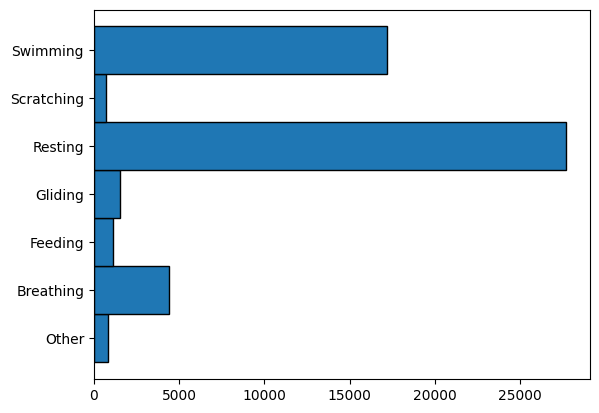

In [ ]:
bins=np.arange(len(CLASSES)+1)-0.5
plt.hist(Y_train,bins,edgecolor="k",orientation='horizontal');
xtics=range(len(CLASSES))
xtics_label=CLASSES
plt.yticks(xtics,xtics_label);

Data need to be balanced

In [ ]:
def balance_dataset(X,Y, threshold):

  index_select=[]
  for beh in range(7) :
    index=np.where(Y==beh)[0]
    if len(index)>threshold:
      index_beh=np.random.choice(index, size=threshold, replace=False)
      index_select.extend(index_beh)
    else :
      index_select.extend(index)

  return X[index_select,:,:], Y[index_select]



In [ ]:
X_train, Y_train=balance_dataset(X_train, Y_train, 1500)

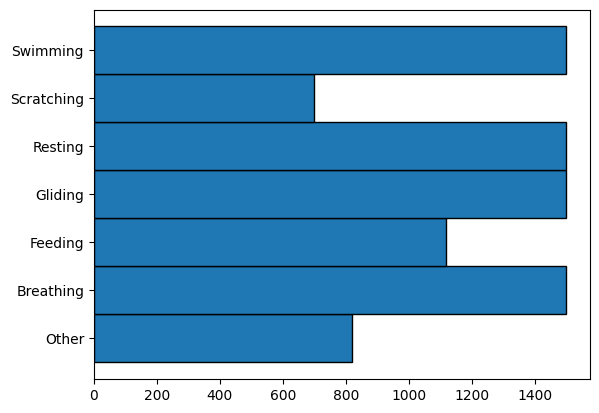

In [ ]:
bins=np.arange(len(CLASSES)+1)-0.5
plt.hist(Y_train,bins,edgecolor="k",orientation='horizontal');
xtics=range(len(CLASSES))
xtics_label=CLASSES
plt.yticks(xtics,xtics_label);

#### Validation dataset

In [ ]:
X_val, Y_val=generate_dataset(NAMES_VAL, Matrices, Labels, WINDOW_SIZE, OVERLAP)
X_val=np.concatenate(X_val, axis=0)
Y_val=np.concatenate(Y_val, axis=0)



CC-07-59_20-05-2018 (7062, 80, 14) (7062,)
CC-07-47_14-02-2018 (1754, 80, 14) (1754,)
CC-07-48_10-10-2018 (1152, 80, 14) (1152,)


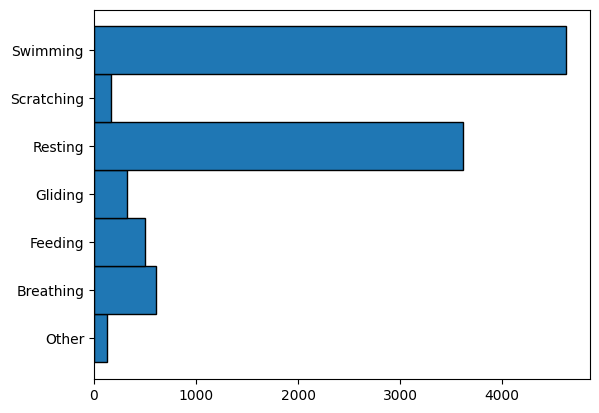

In [ ]:
bins=np.arange(len(CLASSES)+1)-0.5
plt.hist(Y_val,bins,edgecolor="k",orientation='horizontal');
xtics=range(len(CLASSES))
xtics_label=CLASSES
plt.yticks(xtics,xtics_label);

In [ ]:
X_val, Y_val=balance_dataset(X_val, Y_val, 1200)

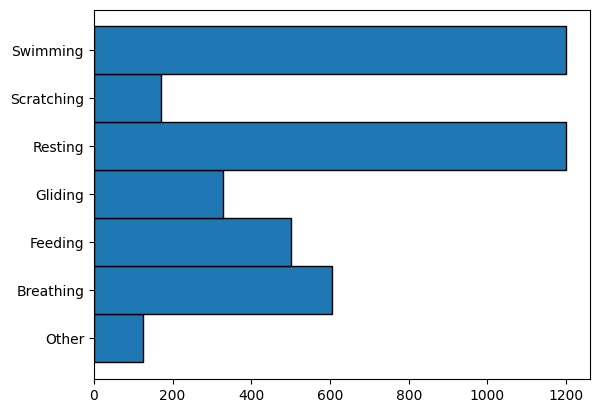

In [ ]:
bins=np.arange(len(CLASSES)+1)-0.5
plt.hist(Y_val,bins,edgecolor="k",orientation='horizontal');
xtics=range(len(CLASSES))
xtics_label=CLASSES
plt.yticks(xtics,xtics_label);

#### Testing dataset

In [ ]:
X_test, Y_test=generate_dataset(NAMES_TEST, Matrices, Labels, WINDOW_SIZE, OVERLAP)
X_test=np.concatenate(X_test, axis=0)
Y_test=np.concatenate(Y_test, axis=0)

CC-07-48_26-05-2018 (4453, 80, 14) (4453,)
CC-07-107_11-02-2019 (5767, 80, 14) (5767,)
CC-07-48_08-10-2018 (8918, 80, 14) (8918,)


### CNN architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool1D, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
def baseline_model( window_size, nb_descriptor):


        cnn_input=Input(shape = (window_size, nb_descriptor))
        feature_extractor = Conv1D(filters = 128, kernel_size = 5, padding='same',activation = 'relu')(cnn_input)
        feature_extractor = Dropout(rate = 0.3)(feature_extractor)
        feature_extractor = MaxPool1D(pool_size=2)(feature_extractor)
        feature_extractor = Conv1D(filters = 128, kernel_size = 5, padding='same', activation = 'relu')(feature_extractor)
        feature_extractor = Dropout(rate=0.3)(feature_extractor)
        feature_extractor = MaxPool1D(pool_size=2)(feature_extractor)
        feature_extractor = Flatten()(feature_extractor)

        x = Dense(units = 100, activation='relu')(feature_extractor)
        x = Dropout(rate=0.3)(x)


        # Model softmax output
        softmax_output=Dense(7, activation = 'softmax')(x)

        # One intput and one output
        model = Model(inputs=cnn_input, outputs=softmax_output)
        model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

        return model

In [ ]:
CNN=baseline_model(80, 14)

In [ ]:
CNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 14)]          0         
                                                                 
 conv1d (Conv1D)             (None, 80, 128)           9088      
                                                                 
 dropout (Dropout)           (None, 80, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 40, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           82048     
                                                                 
 dropout_1 (Dropout)         (None, 40, 128)           0         
                                                             

In [ ]:
#ModelCheckpoint is a function to save the Keras model or model weights at some frequency.
#for that you need to precise the folder where you want to save the weights (filepath),
#if you want to save the bext model or the final model, here we want to save the best model (save_best_only=True)
#precise on each value the function is based to evaluate the best model (monitor='val_accuracy)
#"mode":  the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,

folder_out="/content/drive/MyDrive/Output_Acceleration_data"
dir_out=create_new_folder(folder_out, "CNN")  #Warning: this will clean up the directory if it already exists!
filepath= dir_out+"/weights_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')


we clear the directory: /content/drive/MyDrive/Output_Acceleration_data/model=2024_02_16_CNN


In [ ]:
#we need to transform our Y dataset(class vector) into binary class matrix
Y_train=keras.utils.to_categorical(Y_train,len(CLASSES))
Y_val=keras.utils.to_categorical(Y_val,len(CLASSES))

In [ ]:
Y_train.shape

(8634, 7)

In [ ]:
EPOCHS=30
BATCH_SIZE=200


history = CNN.fit(X_train, Y_train, epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                callbacks=[checkpoint],
                                validation_data=(X_val,Y_val))

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 7.3625 - accuracy: 0.1890
Epoch 1: val_accuracy improved from -inf to 0.30177, saving model to /content/drive/MyDrive/Output_Acceleration_data/model=2024_02_16_CNN/weights_cnn.hdf5
44/44 [==============================] - 18s 380ms/step - loss: 7.3625 - accuracy: 0.1890 - val_loss: 1.9008 - val_accuracy: 0.3018
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/44 [============================>.] - ETA: 0s - loss: 1.8934 - accuracy: 0.2179
Epoch 2: val_accuracy improved from 0.30177 to 0.38363, saving model to /content/drive/MyDrive/Output_Acceleration_data/model=2024_02_16_CNN/weights_cnn.hdf5
44/44 [==============================] - 8s 179ms/step - loss: 1.8936 - accuracy: 0.2181 - val_loss: 1.7233 - val_accuracy: 0.3836
Epoch 3/30
43/44 [============================>.] - ETA: 0s - loss: 1.8206 - accuracy: 0.2595
Epoch 3: val_accuracy improved from 0.38363 to 0.44757, saving model to /content/drive/MyDrive/Output_Acceleration_data/model=2024_02_16_CNN/weights_cnn.hdf5
44/44 [==============================] - 10s 224ms/step - loss: 1.8201 - accuracy: 0.2594 - val_loss: 1.6385 - val_accuracy: 0.4476
Epoch 4/30
43/44 [============================>.] - ETA: 0s - loss: 1.7401 - accuracy: 0.2871
Epoch 4: val_accuracy improved from 0.44757 to 0.44926, saving model to /content/drive/MyDrive/Output_Acceleration_data/model=2024_02_16_CNN/weights_c

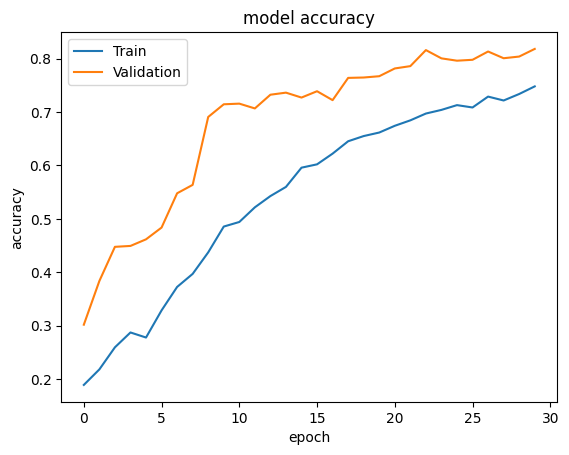

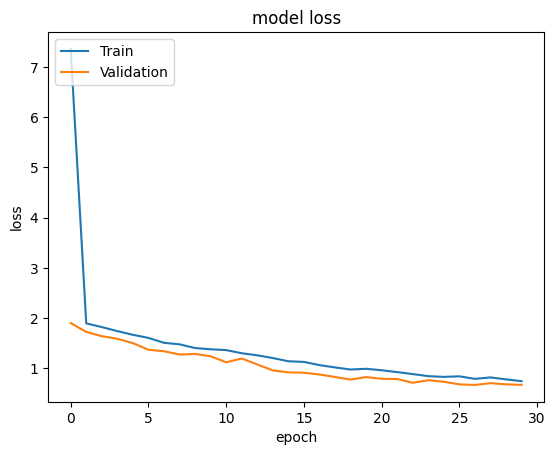

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Save the model


In [ ]:
with open(dir_out+"/model_CNN.json", "w") as json_file:
     json_file.write(CNN.to_json())



In [ ]:
#save the memo and the parameters of the model
memo.to_csv(dir_out+"/memo.csv")

### Evaluate the CNN

In [ ]:
X_test.shape

(19138, 80, 14)

In [ ]:
CNN.load_weights(filepath)

In [ ]:
Predictions_CNN = CNN.predict(X_test)

599/599 [==============================] - 7s 11ms/step


In [ ]:
Predictions_CNN.shape

(19138, 7)

In [ ]:
Predictions_CNN=np.argmax(Predictions_CNN, axis=1)

In [ ]:
CLASSES[0]

'Other'

In [ ]:
unique_labels(Y_test, Predictions_CNN)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize, axe,
                          title,
                          cmap="jet",
                          precision=2,
                         ):


    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)

    np.set_printoptions(precision=precision)


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    print("Confusion matrix, without normalization:")
    print(cm)

    if normalize:
      if axe=="col" :
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
      elif axe=="row":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(cm)


    fig, ax = plt.subplots(figsize=(12,12))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()


Confusion matrix, without normalization:
[[  50   19   81   24   24   43   22]
 [  11 1792   19   24    0    0   26]
 [   6    2  322   15  133   59   12]
 [  13   35   59  709   36   17   75]
 [   7    0  625   43 9198   29    5]
 [  35    0  132    4    8  412   14]
 [ 121  222  663  568   95  288 3041]]
Normalized confusion matrix
[[1.90e-01 7.22e-02 3.08e-01 9.13e-02 9.13e-02 1.63e-01 8.37e-02]
 [5.88e-03 9.57e-01 1.01e-02 1.28e-02 0.00e+00 0.00e+00 1.39e-02]
 [1.09e-02 3.64e-03 5.87e-01 2.73e-02 2.42e-01 1.07e-01 2.19e-02]
 [1.38e-02 3.71e-02 6.25e-02 7.51e-01 3.81e-02 1.80e-02 7.94e-02]
 [7.07e-04 0.00e+00 6.31e-02 4.34e-03 9.28e-01 2.93e-03 5.05e-04]
 [5.79e-02 0.00e+00 2.18e-01 6.61e-03 1.32e-02 6.81e-01 2.31e-02]
 [2.42e-02 4.44e-02 1.33e-01 1.14e-01 1.90e-02 5.76e-02 6.08e-01]]


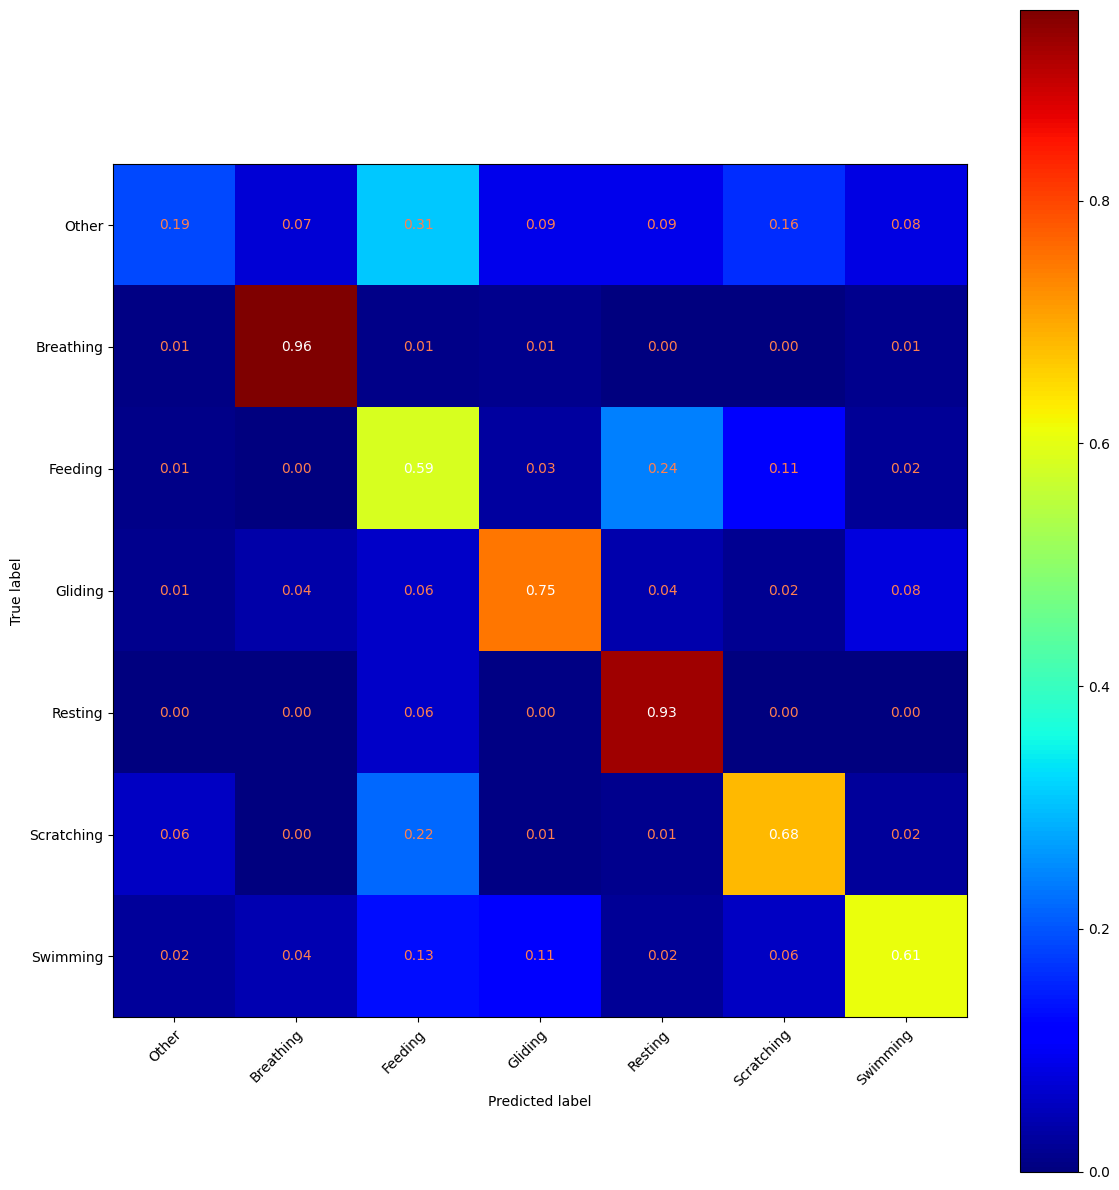

In [ ]:
plot_confusion_matrix(Y_test,Predictions_CNN, CLASSES,True,"row","whole validation")

Confusion matrix, without normalization:
[[  50   19   81   24   24   43   22]
 [  11 1792   19   24    0    0   26]
 [   6    2  322   15  133   59   12]
 [  13   35   59  709   36   17   75]
 [   7    0  625   43 9198   29    5]
 [  35    0  132    4    8  412   14]
 [ 121  222  663  568   95  288 3041]]


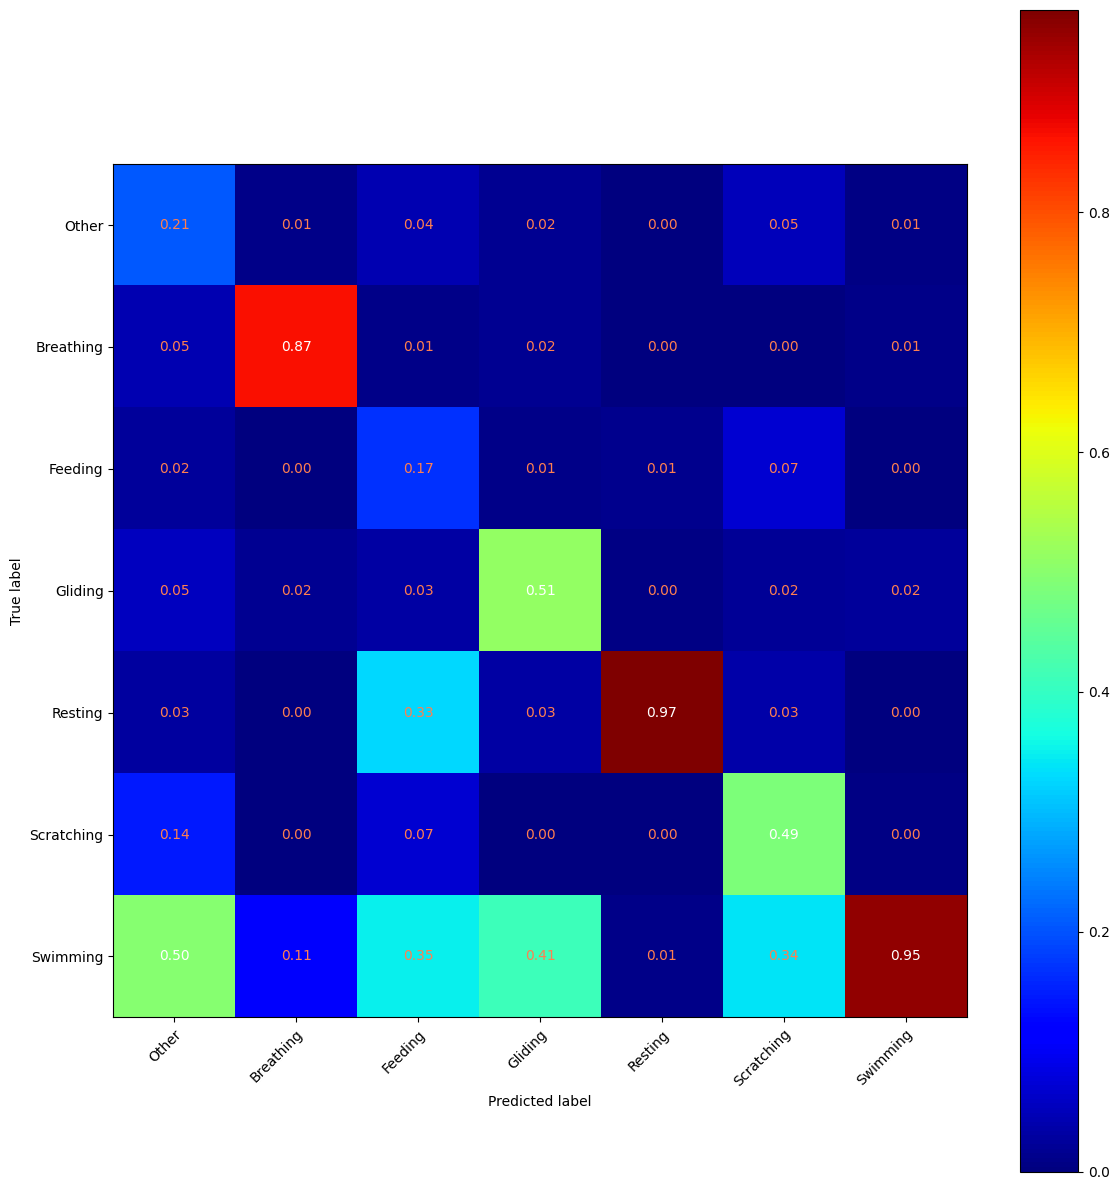

In [ ]:
plot_confusion_matrix(Y_test,Predictions_CNN, CLASSES ,True,"col","whole validation")

In [ ]:

cm = confusion_matrix(Y_test,Predictions_CNN)

print(cm)
TP=np.diag(cm)
FP=np.sum(cm,axis=1)-TP
FN=np.sum(cm,axis=0)-TP
TN=np.ones(len(CLASSES))*np.sum(cm)-TP-FP-FN

Accuracy=(TP+TN)/(TP+TN+FP+FN)
Recall=TP/(TP+FN)
Precision =TP/(TP+FP)
Specificity =TN/(TN+FP)
F1_score=2*(Recall*Precision)/ (Recall+Precision)

[[  50   19   81   24   24   43   22]
 [  11 1792   19   24    0    0   26]
 [   6    2  322   15  133   59   12]
 [  13   35   59  709   36   17   75]
 [   7    0  625   43 9198   29    5]
 [  35    0  132    4    8  412   14]
 [ 121  222  663  568   95  288 3041]]


In [ ]:
df_CNN = pd.DataFrame({'Accuracy': Accuracy, 'Recall': Recall, 'Precision': Precision, 'Specificity': Specificity, 'F1_score': F1_score},
                      index = CLASSES)
df_CNN

,Accuracy,Recall,Precision,Specificity,F1_score
Other,0.978786,0.205761,0.190114,0.988727,0.197628
Breathing,0.981294,0.865700,0.957265,0.995313,0.909183
Feeding,0.905633,0.169385,0.586521,0.986831,0.262857
Gliding,0.952294,0.511175,0.751059,0.986761,0.608323
Resting,0.947487,0.968822,0.928434,0.926483,0.948199
Scratching,0.967133,0.485849,0.680992,0.989448,0.567103
Swimming,0.889696,0.951800,0.608443,0.877250,0.742341


In [ ]:
Global_accuracy=(np.sum(TP)+np.sum(TN))/(np.sum(TP)+np.sum(TN)+np.sum(FP)+np.sum(FN))
print("Global Accuracy :", Global_accuracy)

Global_F1_score=np.mean(df_CNN.F1_score)
print("Global f1-score :", Global_F1_score)

Global Accuracy : 0.946046011674604
Global f1-score : 0.6050904973118459


## Application

In [ ]:
def stick(Y, window_size, overlap):

    size_prediction=int(window_size-overlap*window_size)
    res=[]
    res.append(np.ones(size_prediction)*Y[0])

    for i in range(1,len(Y)):
        res.append(np.ones(size_prediction)*Y[i])

    return np.concatenate(res,axis=0)

In [ ]:
def get_all(turtle_names, matrices, labels, window_size, overlap, model):

    all_pred={}
    all_true={}

    for i,name in enumerate(turtle_names):
        matrix=matrices[name]
        label=labels[name]
        print(name,matrix.shape,label.shape)

        X_cut,Y_cut=sliding_window(matrix, label, window_size, overlap)
        Y_stick=stick(Y_cut, window_size, overlap)
        all_true[name]=Y_stick


        Y_cut_pred_proba=model.predict([X_cut])

        Y_cut_pred=np.argmax(Y_cut_pred_proba, axis=1)

        Y_stick_pred=stick(Y_cut_pred, window_size, overlap)
        all_pred[name]=Y_stick_pred

    return all_pred,all_true

In [ ]:
all_pred,all_true=get_all(NAMES_ALL, Matrices, Labels, WINDOW_SIZE, 0.1, CNN)

CC-07-48_18-02-2019 (559219, 14) (559219,)
243/243 [==============================] - 2s 9ms/step
CC-07-48_06-10-2018 (475183, 14) (475183,)
207/207 [==============================] - 2s 8ms/step
CC-07-48_04-10-2018 (284021, 14) (284021,)
124/124 [==============================] - 1s 8ms/step
CC-07-115_13-05-2019 (731266, 14) (731266,)
318/318 [==============================] - 4s 13ms/step
CC-07-115_14-05-2019 (325009, 14) (325009,)
141/141 [==============================] - 1s 8ms/step
CC-07-48_08-04-2019_1 (157315, 14) (157315,)
69/69 [==============================] - 1s 9ms/step
CC-07-48_08-04-2019_2 (88800, 14) (88800,)
39/39 [==============================] - 0s 8ms/step
CC-07-48_08-04-2019_3 (142801, 14) (142801,)
62/62 [==============================] - 1s 9ms/step
CC-07-48_22-05-2018 (286161, 14) (286161,)
125/125 [==============================] - 1s 9ms/step
CC-07-108_11-02-2019 (160292, 14) (160292,)
70/70 [==============================] - 1s 8ms/step
CC-07-59_20-05-2018 

In [ ]:
def plot_categorical_vector(ax,vector,cat_selected,cat_names,markersize=2,color=None,label=None):

    #listes des couleurs par défaut
    #colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

    for cat in cat_selected:
        ax.set_label("toto")
        here=(vector==cat)
        x_here=np.arange(len(vector))[here]
        y_here=cat*np.ones(len(vector))[here]
        line,=ax.plot(x_here, y_here,'o',markersize=markersize,color=color)


    line.set_label(label)

    ax.set_yticks(range(len(cat_selected)))
    ax.tick_params(colors='coral')
    labels=[]
    for cat in cat_selected:
        labels.append(str(cat)+":"+cat_names[cat])

    ax.set_yticklabels(labels)

In [ ]:
def plot_compa_Y(ax,y,y_pred):

    nb_output=len(CLASSES)
    #class_names=[CLASS.name for CLASS in CLASSES]


    plot_categorical_vector(ax,y,range(nb_output),CLASSES,markersize=3,color="blue",label="Y")
    plot_categorical_vector(ax,y_pred,range(nb_output),CLASSES,markersize=1,color="red",label="Y_pred")

    ax.legend()


In [ ]:
def plot_compa(tortle_names,title,deb=0,fin=-1):
    #deb=0
    #fin=-1
    nb=len(tortle_names)
    fig,axs=plt.subplots(nb,1,figsize=(12,2*nb),sharex=False)
    if nb==1:axs=[axs]

    for i,name in enumerate(tortle_names):
        plot_compa_Y(axs[i],all_true[name][deb:fin],all_pred[name][deb:fin])
        axs[i].set_title(name, color="coral", fontsize=16)

    fig.tight_layout()



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


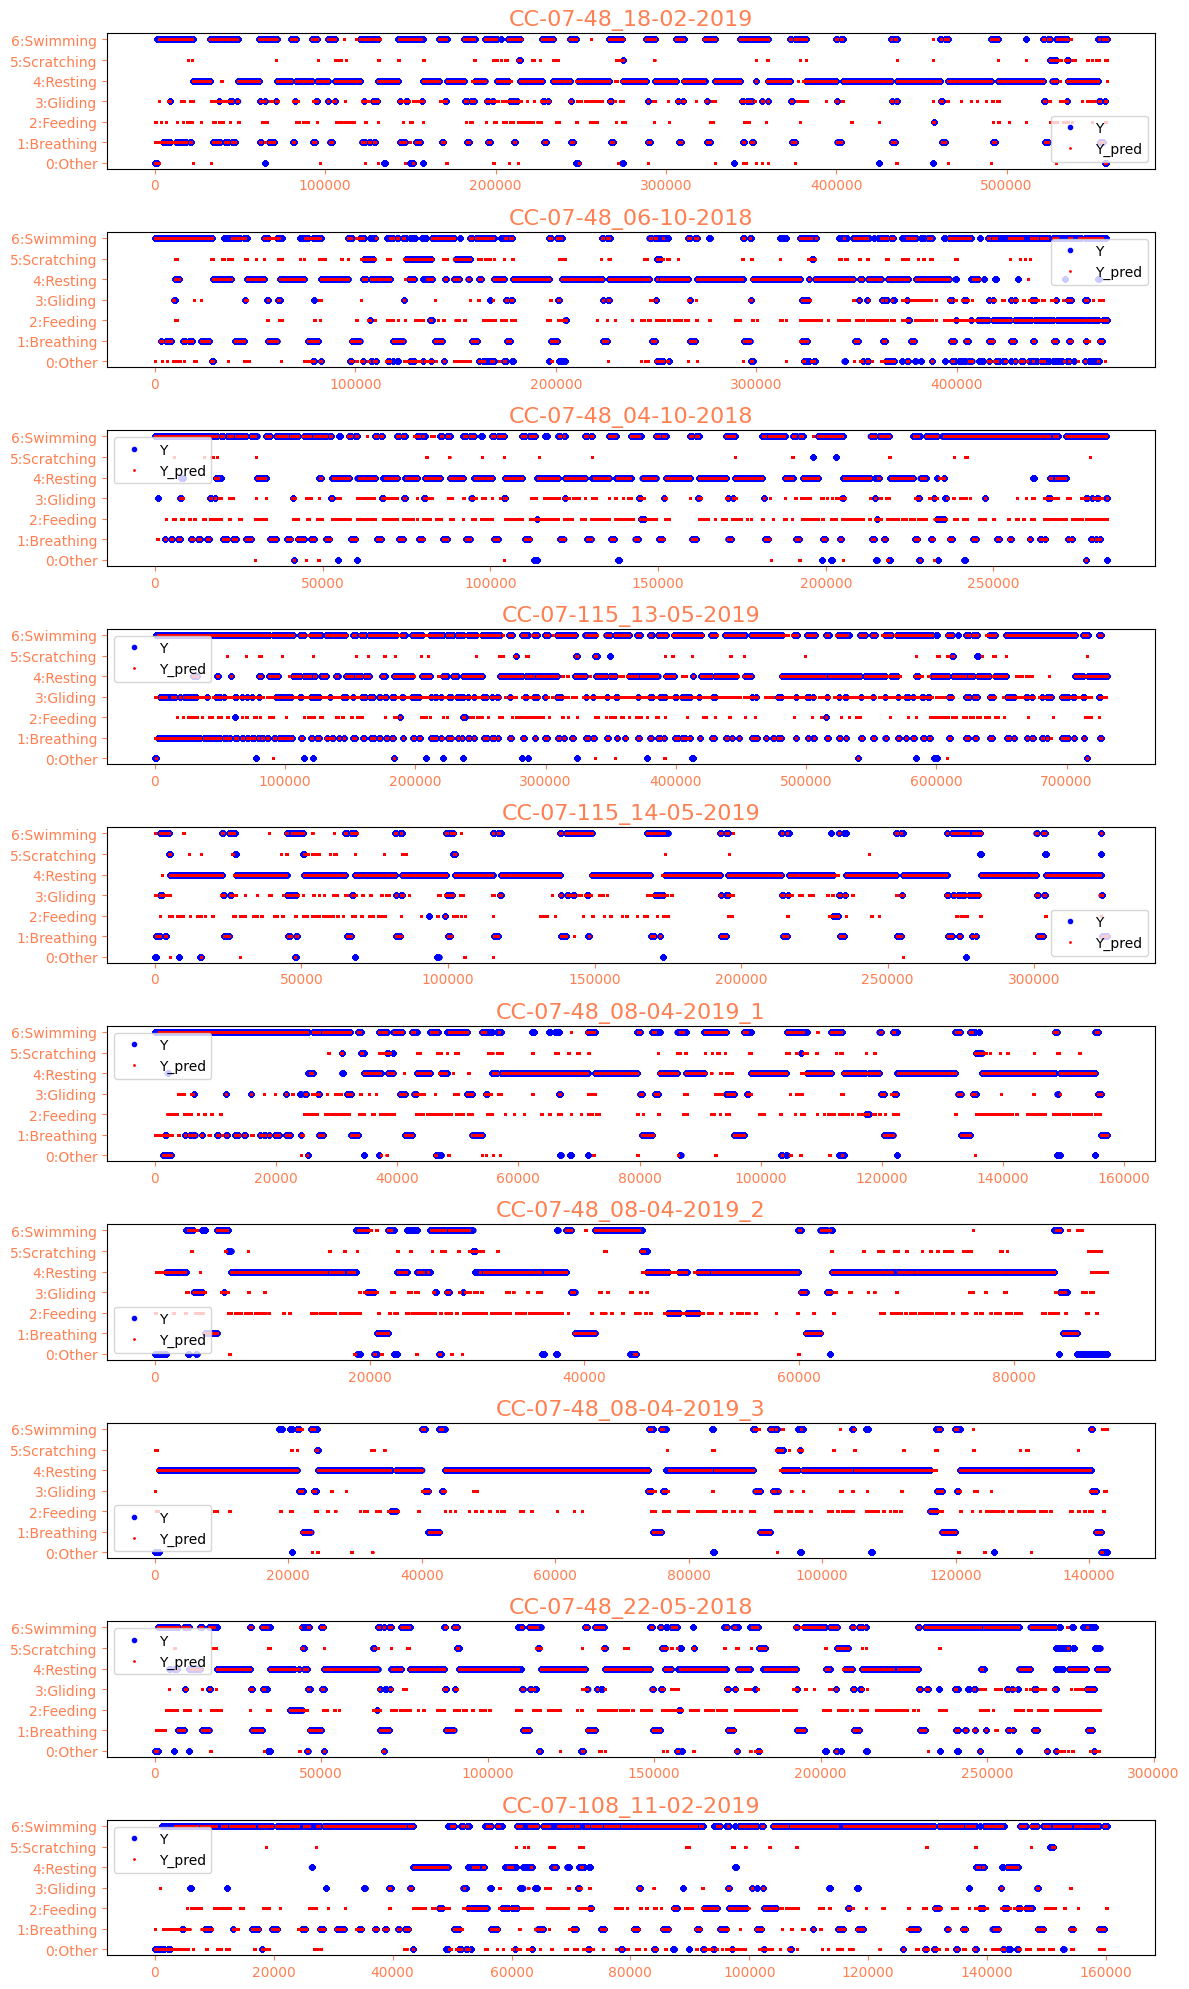

In [ ]:
plot_compa(NAMES_TRAIN,"compa on train")

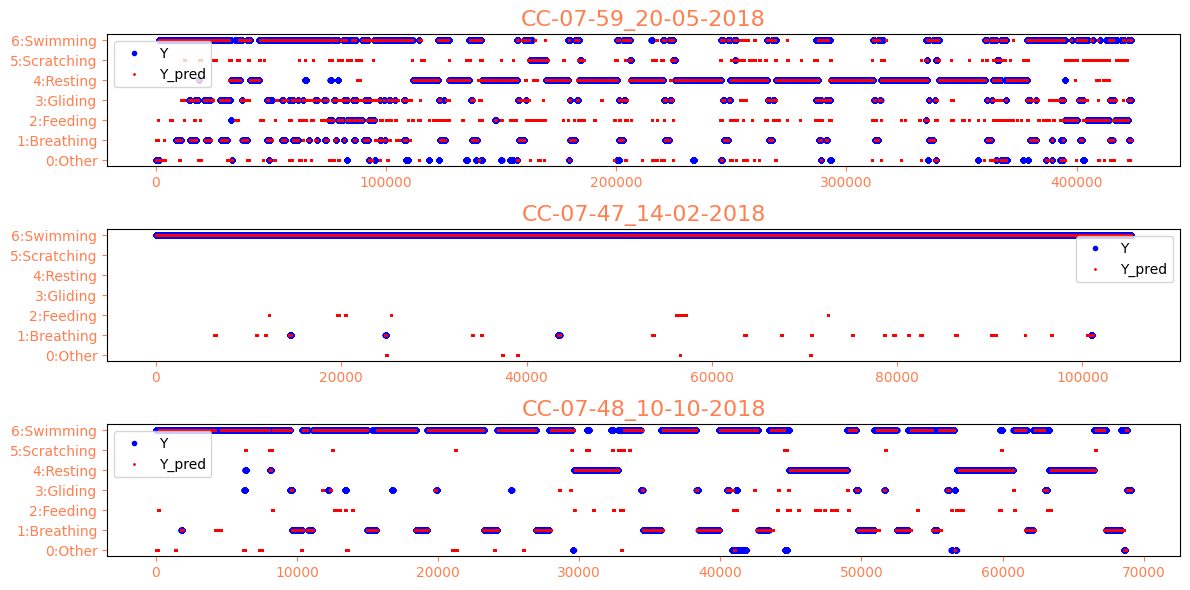

In [ ]:
plot_compa(NAMES_VAL,"compa on val")

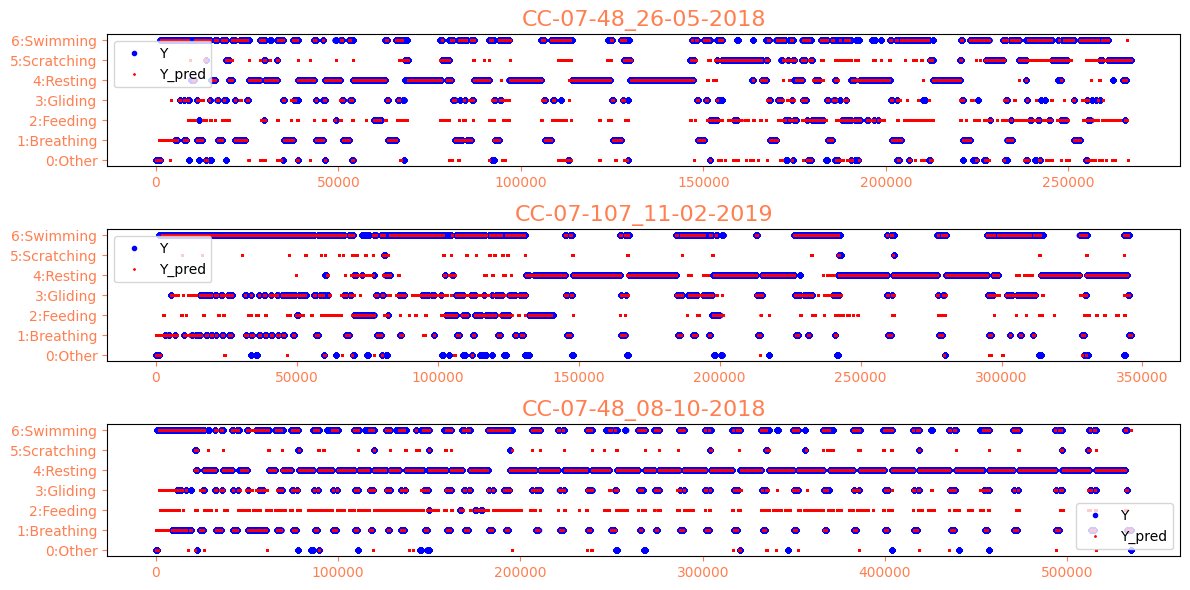

In [ ]:
plot_compa(NAMES_TEST,"compa on val")